In [1]:
import random
from collections import deque
import time
import pickle

import numpy as np
from matplotlib import pyplot as plt
import gym
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam


Using TensorFlow backend.


In [2]:
class DQLSolver:
    def __init__(self, nn, max_batch_size=1024, mini_batch_size=32):
        self._nn = nn
        self._batch = deque(maxlen=max_batch_size)
        self.mini_batch_size = mini_batch_size
    
    def get_action(self, env, state, eps=.2):
        # Choose action at random
        if random.random() < eps:
            return env.action_space.sample()
        return np.argmax(self._nn.predict(np.array([state])))
        
    def remember(self, s, a, r, sn, done):
        self._batch.append((s, a, r, sn, done))
        return
    
    def exp_replay(self, gamma=.99):
        if len(self._batch) < self.mini_batch_size:
            return
        mini_batch = random.sample(self._batch, self.mini_batch_size)
        
        state_vec = []
        q_target_vec = []
        for state, action, reward, state_new, done in mini_batch:
            if done:
                q_update = reward
            else:
                q_update = reward + gamma * np.amax(self._nn.predict(np.array([state_new])))
            q_target = self._nn.predict(np.array([state]))
            q_target[0][action] = q_update
            state_vec.append(state)
            q_target_vec.append(q_target[0])
        
        state_vec = np.array(state_vec)
        q_target_vec = np.array(q_target_vec)
        self._nn.fit(state_vec, q_target_vec, verbose=0, batch_size=self.mini_batch_size//4, epochs=1)
    

In [3]:
env = gym.make('MountainCar-v0')
n_epi = 100

model = Sequential()

model.add(Dense(24, input_shape=env.observation_space.shape, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(env.action_space.n, activation='linear'))
model.compile(loss='mse', optimizer=Adam(lr=.001))
solver = DQLSolver(model)
max_positions = []

In [54]:
start = time.time()
eps = .5
monitor = True



for i_epi in range(n_epi):
    if not i_epi % 5:
        eps = eps/(i_epi//5 + 1)
    
    x_max = -5
    state = env.reset()
    
    for t in range(1000):

        if state[0] > x_max:
            x_max = state[0]
        if not i_epi % 1 and monitor:
            env.render()
        # Choose epsilon greedy action
        action = solver.get_action(env, state, eps=eps)
        # step
        state_new, reward, done, _ = env.step(action)
        
        reward = abs(state[0] + .5)**2 - .2 * abs(state[0] - .5)
        if done and t < 199:
            reward += 1
        solver.remember(state, action, reward, state_new, done)
        # experience replay
        solver.exp_replay()
        
        if done:
            max_positions.append(x_max)
            print(f'maximal x encountered:{x_max}')
            break
            
        state = state_new
    
env.close()
print(f'finished in {time.time() - start} seconds')

maximal x encountered:-0.23590210732109815
maximal x encountered:-0.38028358015348446
maximal x encountered:-0.3785587104624871
maximal x encountered:-0.3071663342714253
maximal x encountered:-0.31246048991423087
maximal x encountered:-0.400271893925957
maximal x encountered:-0.27994109052595284
maximal x encountered:0.05108851586255156
maximal x encountered:0.157400420537714
maximal x encountered:0.0033482692302112278
maximal x encountered:0.4838684949988205
maximal x encountered:0.17612165127996302
maximal x encountered:0.4993747785021086
maximal x encountered:0.4534429467639063
maximal x encountered:0.4753233592789814
maximal x encountered:-0.1194124670714407
maximal x encountered:0.4928311980357733
maximal x encountered:0.4763897753989178
maximal x encountered:0.48920873492404676
maximal x encountered:0.4869007238355066
maximal x encountered:0.4979314215122791
maximal x encountered:0.4779662342730699
maximal x encountered:0.45543020632444275
maximal x encountered:0.4869007238355066

In [62]:
pickle.dump(solver, open('mountain_car_models/100iter.pkl','wb'))

100iter.pkl


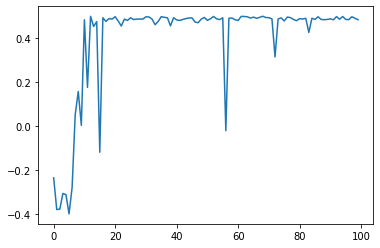

In [55]:
plt.plot(max_positions)

In [4]:
solver = pickle.load(open('mountain_car_models/100iter.pkl', 'rb'))

In [72]:
!ls  mountain_car_models/

100iter.pkl


In [7]:
x_max = -5
n_epi = 30
monitor = True

for i_epi in range(n_epi):
    state = env.reset()
    
    for t in range(1000):

        if state[0] > x_max:
            x_max = state[0]
        if not i_epi % 1 and monitor:
            env.render()
        # Choose epsilon greedy action
        action = solver.get_action(env, state, eps=0)
        # step
        state_new, reward, done, _ = env.step(action)
        
        reward = abs(state[0] + .5)**2 - .2 * abs(state[0] - .5)
        
        if done:
            break
            
        state = state_new
    
env.close()
print(f'finished in {time.time() - start} seconds')

NameError: name 'start' is not defined